In [2]:
import sys, os

sys.path.append('/cr/users/filip/bin')

from utils.binaries import *
from utils.plotting import *

from utils.Auger.SD import Monitoring

10:41:57 [INFO] utils          -- (+81953ms) -- import logging
10:41:57 [INFO] utils.binaries -- (  +142ms) -- import numpy as np
10:41:57 [INFO] utils.binaries -- (    +8ms) -- import uncertainties
10:41:57 [INFO] utils.binaries -- (  +195ms) -- import pandas as pd
10:41:57 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
10:41:58 [INFO] utils.plotting -- (  +313ms) -- import matplotlib.pyplot as plt
10:41:58 [INFO] utils.plotting -- (  +379ms) -- import seaborn as so
10:41:58 [DBUG] utils.plotting -- (    +7ms) -- font size set to 9.5
10:41:58 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
10:41:58 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
10:41:58 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
10:41:58 [DBUG] utils.plotting -- (    +0ms) -- usetex set to False
10:41:58 [INFO] utils.plotting -- (    +3ms) -- import plotting.tools as plot


In [3]:
ssd_fmt = np.dtype(('<i4, (2049,)i2'))
# ssd = np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/Peru/randoms0000.ssd', dtype=ssd_fmt)

wcd_fmt = np.dtype(('<i4, (2049,)i2', (3,)))
# wcd = np.fromfile('/cr/data02/AugerPrime/UUB/UubRandoms/2022_11/Peru/randoms0000.wcd', dtype=wcd_fmt)

In [30]:
assert ssd[0][0] == wcd[0,0][0], 'Beggining of DAQ for WCD and SSD do not match up'
assert ssd[-1][0] == wcd[-1,0][0], 'End of DAQ for WCD and SSD do not match up'

t_begin, t_end = ssd[0][0], ssd[-1][0]

from datetime import datetime

daq_begin = datetime.fromtimestamp(t_begin)
daq_end = datetime.fromtimestamp(t_end)
print(daq_begin, daq_end)


2022-11-15 20:16:09 2022-11-15 20:16:59


In [2]:
M = Monitoring.Monit(2023, range(1, 13), 1)

08:22:13 [INFO] SD.Monitor     -- (+16201ms) -- received 12 file(s) as input
08:22:16 [INFO] SD.Monitor     -- ( +3026ms) -- View monit keys with self.keys()


In [3]:
t_vals = M('fTime', 699)
v_vals = M('fPeak', 1737)

08:22:19 [INFO] SD.Monitor     -- ( +2414ms) -- found 2584 entries for key fTime and station #699
08:22:20 [INFO] SD.Monitor     -- ( +1473ms) -- found 2374 entries for key fPeak and station #1737


In [ ]:
plt.scatter(t_vals, v_vals[:, 0])
plt.scatter(t_vals, v_vals[:, 1])
plt.scatter(t_vals, v_vals[:, 2])

In [ ]:
print(len(t_vals), len(v_vals))

In [41]:
print(indices[-1])

800


In [179]:
from datetime import datetime
from datetime import timedelta
from scipy.stats import zscore

IDs = {'NuriaJr' : 56, 
       'Peru' : 1737, 
       'Granada' : 1738, 
       'Jaco' : 1742, 
       'LeQuiDon' : 1744, 
       'Svenja' : 1733, 
       'Nadia' : 1723,
       'USA' : 1251, 
       'Vegetta' : 1732, 
       'Virginia' : 699, 
       'Constanza' : 734, 
       'Lucho' : 972
       }

def get_vem_approximate(station, date, plot=False):

    from tabulate import tabulate

    try:
        indices = range(len(os.listdir(f'/cr/data02/AugerPrime/UUB/UubRandoms/{date}/{station}/')) // 2)

        first_ssd_file = f'/cr/data02/AugerPrime/UUB/UubRandoms/{date}/{station}/randoms{indices[0]:04}.ssd'
        last_ssd_file = f'/cr/data02/AugerPrime/UUB/UubRandoms/{date}/{station}/randoms{indices[-1]:04}.ssd'

        # we could technically also just read the first bits in the file, but I'm too lazy to think about that
        DAQ_begin = datetime.fromtimestamp(np.fromfile(first_ssd_file, dtype=ssd_fmt)[0][0])
        DAQ_end = datetime.fromtimestamp(np.fromfile(last_ssd_file, dtype=ssd_fmt)[-1][0])               
    except FileNotFoundError:
        
        try: 
            t_begin, t_end = np.loadtxt(f"/cr/tempdata01/filip/UubRandoms/{date}/converted/timestamps/{station}.dat", unpack = True, usecols = [1, 2])
            DAQ_begin, DAQ_end = datetime.fromtimestamp(np.min(t_begin)), datetime.fromtimestamp(np.max(t_end))

        except FileNotFoundError:
            sys.exit('Requested dataset does not exist!')

    YYYY, MM, DD1 = [(DAQ_begin - timedelta(days=1)).__getattribute__(x) for x in ['year', 'month', 'day']]
    DD2 = (DAQ_end + timedelta(days=1)).day                         # add 2 days since range is [low, high)

    M = Monitoring.Monit(YYYY, MM, range(DD1, DD2))
    t = M('fTime', IDs[station])
    p = M('fPeak', IDs[station])
    
    """because why the fuck should monitoring provide sequential data?"""
    sort = np.argsort(t)
    t, p = t[sort], p[sort]

    """remove outliers where something obviously went wrong"""
    mask = [np.all(point < 3) for point in np.abs(zscore(p))]       # 3 sigma cut = 99%
    t, p = t[mask], p[mask]

    cut_index = np.argmax(np.diff(t)) + 1
    vem_before, vem_after = p[:cut_index], p[cut_index:]
    weights = np.linspace(1, 0, 5)
    average_before = np.mean(vem_before[-5:], axis=0)
    average_after = np.mean(vem_after[:5], axis=0)

    closest_to_start_DAQ = before = np.argmin(np.abs(t - datetime.timestamp(DAQ_begin)))
    closest_to_end_DAQ = after = np.argmin(np.abs(t - datetime.timestamp(DAQ_end)))
    closest_is_before_DAQ = t[closest_to_end_DAQ] > datetime.timestamp(DAQ_end)
    closest_is_after_DAQ = t[closest_to_start_DAQ] < datetime.timestamp(DAQ_begin)

    begin = average_before if closest_is_after_DAQ else average_after
    end = average_after if closest_is_before_DAQ else average_before
    vem_approximate = np.round(0.5 * (begin + end), 2)
    
    table = []
    fluctuations_before = np.std(vem_before, axis=0) / np.mean(vem_before, axis=0) * 100
    jump = (vem_after[0] - vem_before[-1]) / vem_before[-1] * 100
    fluctuations_after = np.std(vem_after, axis=0) / np.mean(vem_after, axis=0) * 100
    

    for i, (fb, j, fa) in enumerate(zip(fluctuations_before, jump, fluctuations_after)):
        table.append([f"PMT #{i}", f"{fb:.2f}%", f"{'+' if j>0 else ''}{j:.2f}%", f"{fa:.2f}%"])
    print(f'\nStability characteristics for: {station} / {date}')
    print(tabulate(table, headers=['', 'before', 'jump', 'after'], tablefmt='grid'))

    if plot:
        t_before, t_after = [datetime.fromtimestamp(x) for x in t[:cut_index]], [datetime.fromtimestamp(x) for x in t[cut_index:]]
        
        plt.axvline(DAQ_begin, c='gray', ls='--', zorder=10)
        plt.axvline(DAQ_end, c='gray', ls='--', zorder=10)

        plt.text(DAQ_begin + 0.5 * (DAQ_end - DAQ_begin), 
                 np.mean(vem_approximate), "UUB Randoms DAQ", 
                 rotation=90,
                 horizontalalignment='center',
                 verticalalignment='center',
                 color='gray',
                 zorder=10)

        plt.axhline(vem_approximate[0], c='steelblue', ls='--', lw=0.7)
        plt.axhline(vem_approximate[1], c='orange', ls='--', lw=0.7)
        plt.axhline(vem_approximate[2], c='green', ls='--', lw=0.7)

        plt.scatter(t_before, vem_before[:, 0], marker='x', c='steelblue')
        plt.scatter(t_after, vem_after[:, 0], marker='+', c='steelblue')
        plt.scatter(t_before, vem_before[:, 1], marker='x', c='orange')
        plt.scatter(t_after, vem_after[:, 1], marker='+', c='orange')
        plt.scatter(t_before, vem_before[:, 2], marker='x', c='green')
        plt.scatter(t_after, vem_after[:, 2], marker='+', c='green')

    return vem_approximate

12:34:37 [INFO] SD.Monitor     -- (+54981ms) -- received 3 file(s) as input


12:34:38 [INFO] SD.Monitor     -- (  +715ms) -- View monit keys with self.keys()
12:34:38 [INFO] SD.Monitor     -- (  +123ms) -- found 251 entries for key fTime and station #1733
12:34:38 [INFO] SD.Monitor     -- (  +362ms) -- found 251 entries for key fPeak and station #1733



Stability characteristics for: Svenja / 2022_11
+--------+----------+--------+---------+
|        | before   | jump   | after   |
+========+==========+========+=========+
| PMT #0 | 0.56%    | +8.04% | 0.38%   |
+--------+----------+--------+---------+
| PMT #1 | 0.89%    | +7.63% | 1.72%   |
+--------+----------+--------+---------+
| PMT #2 | 1.39%    | +8.30% | 1.40%   |
+--------+----------+--------+---------+


array([157.95, 170.95, 151.03], dtype=float32)

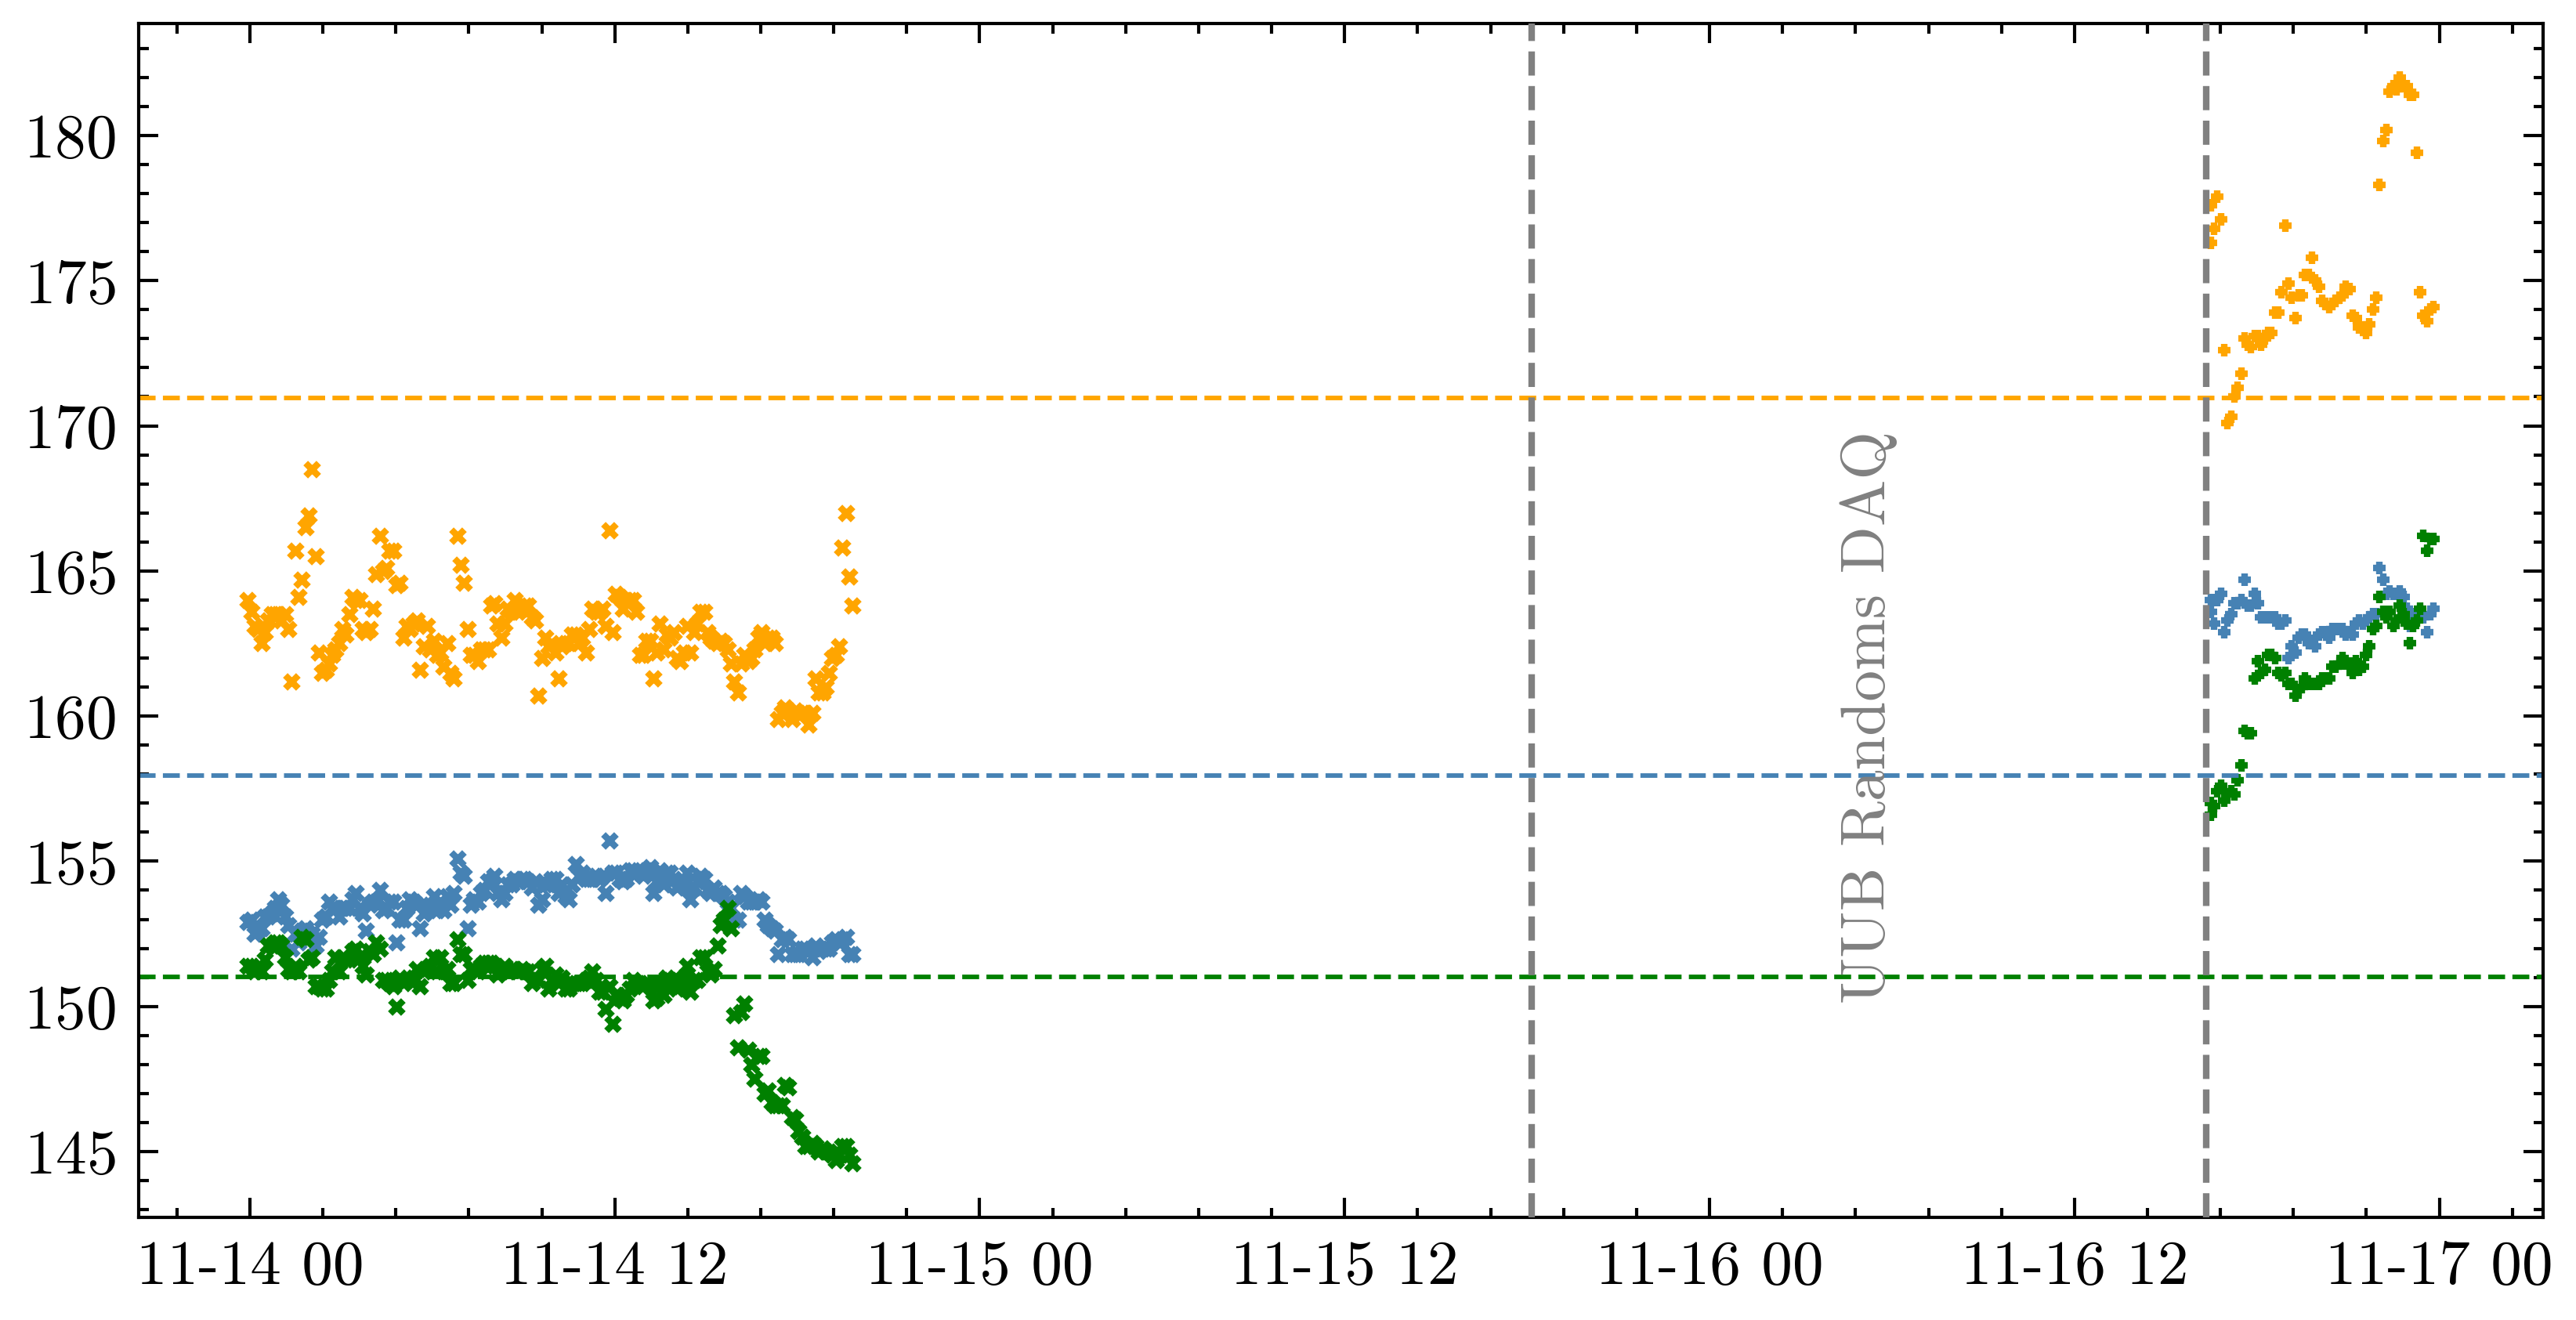

In [182]:
get_vem_approximate('Svenja', '2022_11', plot=True)

In [112]:
a = datetime(2023, 10, 31)
b = datetime(2024, 3, 12)

In [120]:
print(a + 0.5 *  (b - a))

2024-01-05 12:00:00
